In [16]:
import funzioni01 as f1
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq.job import job_monitor
#from qiskit.providers.ibmq import least_busy
from copy import deepcopy
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.circuit import Parameter
import time
import qiskit.quantum_info as qi
from qiskit.utils import QuantumInstance
import qiskit.ignis.mitigation.measurement as mc
#from qiskit.result import marginal_counts
from sympy import *
from sympy.solvers import solve
from sympy import Symbol
import openql as ql
from sympy.physics.quantum import TensorProduct as Tp
from sympy import sqrt, cos, sin, acos, asin, atan
import numpy as np
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute


In [17]:
e, alpha, theta, ar1, ai1, br1, bi1, ar2, ai2, br2, bi2 = symbols("e a t ar1 aI1 ar2 aI2 br1 bI1 br2 bI2")

a1=ar1+I*ai1
a2=ar2+I*ai2

b1=br1+I*bi1
b2=br2+I*bi2

def rz(alpha):
    return Matrix([
        [e**(1j*alpha/2),0],
        [0,e**(-1j*alpha/2)]
    ])

def ry(theta):
    return Matrix([
        [cos(theta/2),sin(theta/2)],
        [-sin(theta/2),cos(theta/2)]
    ])

cx_10= Matrix([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
])

A = Matrix([
    [a1,-b1.conjugate()],
    [b1,a1.conjugate()]
])

B = Matrix([
    [a2,-b2.conjugate()],
    [b2,a2.conjugate()]
])

In [18]:
precision=20
tempo=1 # np.pi/3
steps=40

Un=f1.Trotter_N_approx(steps=steps, tempo=tempo, precision=precision)
gate_1, gate_2 = f1.simplyfied_gates_matricies(Un, precision=precision)

U=(Tp(gate_2,eye(2))*Tp(eye(2),gate_1)).evalf(precision)

-3.0396427099561910246
0.85993638146269324404 0.85993638146269550072


In [19]:
U

Matrix([
[1.0,                                                   0,                                                     0,                                                 0,                                                  0,                                                     0,                                                   0,   0],
[  0, -0.49493344403534748649 + 0.050633984750343286056*I,    -0.77712469893046513474 - 0.38542740934687751208*I,                                                 0,                                                  0,                                                     0,                                                   0,   0],
[  0,  0.10209164994632472077 - 0.050633984750343202056*I, -0.065019902191664535617 - 0.0066518372838155353486*I,                                                 0, -0.38104046771933442838 - 0.91517748111473218439*I,                                                     0,                                                   0,   0]

In [20]:
Un

Matrix([
[-0.65364362086361190759 + 0.75680249530792825746*I,                                                   0,                                                    0,                                                   0,                                                   0,                                                    0,                                                   0,                                                  0],
[                                                 0,  -0.49493344403534750088 - 0.05063398475034253539*I, -0.056618526881940844039 - 0.050633984750343132813*I,                                                   0,  -0.10209164994632498196 + 0.85807046480861542896*I,                                                    0,                                                   0,                                                  0],
[                                                 0, -0.10209164994632474886 - 0.050633984750343145436*I,   -0.49493344403534768961 + 0.858

In [21]:
print(sin(tempo).evalf(10),"\n",Un[3*8+6]+Un[5*8+6]+Un[6*8+6])

0.8414709848 
 -0.65364362086361333685 + 0.7568024953079298269*I


In [22]:
print(Un[3*8+6]-U[3*8+6],"\n",Un[5*8+6]-U[5*8+6],"\n",Un[6*8+6]-U[6*8+6])

-3.2835211024489271286e-16 + 2.2399210307735839542e-15*I 
 -2.8081577421203412354e-17 + 5.6620287936128129921e-17*I 
 -1.4385584059693409809e-17 + 7.5066622060341540307e-16*I


In [23]:
M=Tp(rz(-np.pi),rz(-np.pi))*Tp(eye(2),ry(-np.pi/2))*cx_10*Tp(A,B)*cx_10*Tp(eye(2),ry(np.pi/2))*Tp(rz(np.pi),rz(np.pi))


In [24]:
AB_1=cx_10*Tp(eye(2),ry(-np.pi/2))*Tp(rz(-np.pi/2),rz(-np.pi/2))*gate_1*Tp(rz(np.pi/2),rz(np.pi/2))*Tp(eye(2),ry(np.pi/2))*cx_10
AB_2=cx_10*Tp(eye(2),ry(-np.pi/2))*Tp(rz(-np.pi/2),rz(-np.pi/2))*gate_2*Tp(rz(np.pi/2),rz(np.pi/2))*Tp(eye(2),ry(np.pi/2))*cx_10


In [25]:
AB_1

Matrix([
[0.25253327798232636899 + 0.025316992375171638539*I, 0.74746672201767372808 - 0.025316992375171642514*I,   0.38856234946523249848 + 0.19271370467343872187*I,   0.38856234946523255949 + 0.19271370467343875213*I],
[0.74746672201767372808 - 0.025316992375171642514*I, 0.25253327798232613427 + 0.025316992375171646489*I,  -0.38856234946523255949 - 0.19271370467343875213*I,   -0.3885623494652326205 - 0.19271370467343878239*I],
[-0.38856234946523249848 + 0.19271370467343872187*I,  0.38856234946523255949 - 0.19271370467343875213*I,  0.25253327798232636899 - 0.025316992375171638539*I, -0.74746672201767372808 - 0.025316992375171642514*I],
[-0.38856234946523255949 + 0.19271370467343875213*I,   0.3885623494652326205 - 0.19271370467343878239*I, -0.74746672201767372808 - 0.025316992375171642514*I,  0.25253327798232613427 - 0.025316992375171646489*I]])

In [26]:
AB_2

Matrix([
[                            0.56568550072261933976,                            0.43431449927738070814,  0.19052023385966718041 + 0.45758874055736601107*I,  0.19052023385966721033 + 0.45758874055736608291*I],
[                            0.43431449927738070814,                            0.56568550072261920337, -0.19052023385966721033 - 0.45758874055736608291*I, -0.19052023385966724024 - 0.45758874055736615476*I],
[-0.19052023385966718041 + 0.45758874055736601107*I, 0.19052023385966721033 - 0.45758874055736608291*I,                             0.56568550072261933976,                            -0.43431449927738070814],
[-0.19052023385966721033 + 0.45758874055736608291*I, 0.19052023385966724024 - 0.45758874055736615476*I,                            -0.43431449927738070814,                             0.56568550072261920337]])

In [27]:
AB_2[0]-AB_2[1]

0.13137100144523863162

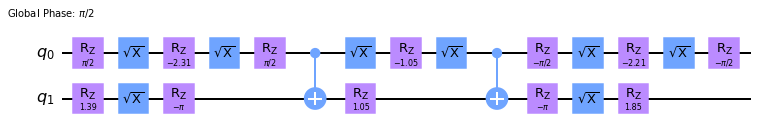

In [28]:
qc_aus=QuantumCircuit(2)
qc_aus.unitary(AB_1, [0,1])

gate=transpile(qc_aus,basis_gates=["cx","rz","x","sx"])
gate.draw(output="mpl")